In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import Angle
import scipy.fft as fft
from image_code import image_calculation_functions as ic

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
theta_p = 181
phi_p = 361
phi = np.linspace(-180,180,phi_p)*np.pi/180
theta = np.linspace(0,90,int(theta_p/2)+1)*np.pi/180
P,T = np.meshgrid(phi,theta)


In [3]:
far_array=np.load('/data4/nmahesh/edges/Lunar/array_layout/farside_array_nooffset.npy')

In [4]:

beam_squarel,ethetal, ephil=ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p1-1MHz_regolith-0',31,theta_p,phi_p)
beam_squarel90,ethetal90,ephil90=ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p1-1MHz_regolith-90',31,theta_p,phi_p)

beam_squareh,ethetah, ephih = ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p4-40MHz_regolith',10,theta_p,phi_p)
beam_squareh90,ethetah90,ephih90 = ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p4-40MHz_regolith-90',10,theta_p,phi_p)


In [5]:

sample = 1

    
if sample==0:
    wav = 500 #in m; f = 0.6 MHz
    index = 17
    freq = '0p6_MHz'
    beam_square,etheta, ephi = beam_squarel,ethetal, ephil
    beam_square90,etheta90,ephi90 = beam_squarel90,ethetal90,ephil90
    factor =150
    
elif sample==1:
    wav = 150 # in m; f = 2MHz
    index = 3
    freq = '2_MHz'
    beam_square,etheta, ephi = beam_squareh,ethetah, ephih
    beam_square90,etheta90,ephi90=beam_squareh90,ethetah90,ephih90
    factor =500

elif sample==2:
    wav = 30 # in m; f = 10MHz
    index = 4
    freq = '10_MHz'
    beam_square,etheta, ephi = beam_squareh,ethetah, ephih
    beam_square90,etheta90,ephi90=beam_squareh90,ethetah90,ephih90
    factor =2500
    
f = 300/wav

l_grid = np.linspace(-1,1,int(factor))
m_grid = l_grid
L,M = np.meshgrid(l_grid,m_grid)

q = L**2+M**2
el = np.sqrt(1 - q)
el[q>=1] = 0
p =-np.arctan2(M,L) 
t = np.pi/2 - np.arcsin(el)#-np.arcsin(L,(np.sin(p)))+np.pi/2

etheta = np.roll(etheta[:,:,:-1],180,axis=2)/np.max(etheta[index,:,:])
etheta90 = np.roll(etheta90[:,:,:-1],180,axis=2)/np.max(etheta90[index,:,:])
ephi = np.roll(ephi[:,:,:-1],180,axis=2)/np.max(ephi[index,:,:])
ephi90 = np.roll(ephi90[:,:,:-1],180,axis=2)/np.max(ephi90[index,:,:])







<ipython-input-5-f2a9d76655e8>:35: RuntimeWarning: invalid value encountered in sqrt
  el = np.sqrt(1 - q)


In [6]:
etheta[index,0,:]=0
etheta90[index,0,:]=0
ephi[index,0,:]=0
ephi90[index,0,:]=0

In [7]:
beam_etheta = ic.beam_interpolate(etheta[index],theta,phi[:-1],t,p)
beam_etheta90 = ic.beam_interpolate(etheta90[index],theta,phi[:-1],t,p)

beam_ephi = ic.beam_interpolate(ephi[index],theta,phi[:-1],t,p)
beam_ephi90 = ic.beam_interpolate(ephi90[index],theta,phi[:-1],t,p)



In [8]:
cygA_ra = Angle('19 59 28.35645829',unit=u.hourangle)
cygA_dec = Angle('+40 44 02.0966496', unit=u.degree)

casA_ra = Angle('23 23 24.000',unit=u.hourangle)
casA_dec = Angle('+58 48 54.00', unit=u.degree)

tauA_ra = Angle('05 34 31.94',unit=u.hourangle)
tauA_dec = Angle('+22 00 52.2', unit=u.degree)

sgrA_ra = Angle('17 45 40.03599',unit=u.hourangle)
sgrA_dec = Angle('-29 00 28.1699', unit=u.degree)

ra_list = [cygA_ra, casA_ra, tauA_ra, sgrA_ra]
dec_list = [cygA_dec, casA_dec, tauA_dec, sgrA_dec]
flux_list = [13500, 10000, 28000, 10000]

In [9]:
off = np.linspace(-12,12,24)*u.hour
cyg_a_altaz = np.zeros((len(off),2))
cyg_A = ic.processed_source()



for i in range(len(off)):
    cyg_A.init_skycoord('19 59 28.35645829 +40 44 02.0966496', Time.now()+off[i])
    cyg_a_altaz[i] = cyg_A.obj_a_altaz
    
s_index = np.where(cyg_a_altaz == np.max(cyg_a_altaz[:,0]))[0]
time = Time.now()+off[10]


In [10]:
t2 = Time(time, scale='utc',location=('180d', '0d'))
lst = t2.sidereal_time('apparent').value
print(t2,lst)

2022-05-03 17:15:57.711102 20.038292230999357


In [11]:
sky_obj = ic.processed_source()
sky_obj.init_skycoords(ra_list,dec_list,flux_list,time)

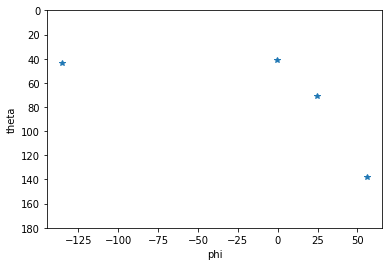

In [12]:
sky_obj.plot_skymap()

In [13]:
sky_obj.tp_to_lm(90,l_grid,m_grid)


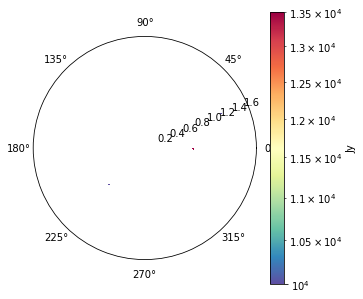

In [14]:
fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
p1 =ax.pcolormesh(p,t,sky_obj.sky_map,cmap='Spectral_r',norm= LogNorm())#vmin=-10, vmax =1000)
ax.set_ylim([0,95*np.pi/180])
plt.colorbar(p1, ax=ax,label='Jy')

In [15]:
sky_obj.calculate_delphi(50,wav,L,M)

In [16]:
sky_obj.make_sky_stokes()

In [17]:
M_rego_wavno1 = np.load('/data4/nmahesh/edges/Lunar/M_rego_wavno1.npy')
M_rego_wav1 = np.load('/data4/nmahesh/edges/Lunar/M_rego_wav1.npy')

In [18]:
M_lm = np.zeros((16,factor,factor))
M_no_lm = np.zeros((16,factor,factor))
for i in range(len(M_rego_wav1[:,0,0])):
    M_lm[i,:,:] = ic.beam_interpolate(M_rego_wav1[i,:91,:360],theta,phi[:-1],t,p)
    M_no_lm[i,:,:] = ic.beam_interpolate(M_rego_wavno1[i,:91,:360],theta,phi[:-1],t,p)

<ipython-input-18-ea2a74cba06e>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  M_lm[i,:,:] = ic.beam_interpolate(M_rego_wav1[i,:91,:360],theta,phi[:-1],t,p)
<ipython-input-18-ea2a74cba06e>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  M_no_lm[i,:,:] = ic.beam_interpolate(M_rego_wavno1[i,:91,:360],theta,phi[:-1],t,p)


In [19]:
del_u,del_v,del_w = ic.uvcal(0,0,wav,50,50)
M_in = np.zeros((4,4, len(theta), len(phi)),dtype='complex')
for i in range(len(theta)):
    for j in range(len(phi)):


        l = np.sin(theta[i])*np.cos(phi[j])
        m = np.sin(theta[i]) * np.sin(phi[j])                             
        del_phi = 2*np.pi* (del_u*l + del_v*m)
        J = np.array([[1,0],[0,np.exp(1j*del_phi)]])

        M_in[:,:,i,j] = 0.5 * np.dot(np.array([[1,0,0,1],[1,0,0,-1],[0,1,1,0],[0,-1j,1j,0]]) , np.kron(np.conj(J),J)).dot(np.array([[1,1,0,0],[0,0,1,1j],[0,0,1,-1j],[1,-1,0,0]]))
       

In [20]:
M_in_lm = np.zeros((4,4,factor,factor),dtype = np.complex128)
for i in range(len(M_in_lm[:,0,0,0])):
    for j in range(len(M_in_lm[0,:,0,0])):
        M_in_lm[i,j,:,:] = ic.beam_interpolate(M_in[i,j,:91,:360],theta,phi[:-1],t,p)
    

In [21]:
vis_off = sky_obj.make_pseudo_vis_muller(M=M_lm/np.max(M_lm[0]))
vis = sky_obj.make_pseudo_vis_muller(M=M_no_lm/np.max(M_no_lm[0]))

In [22]:
beam_ft = sky_obj.fourier_vis_muller(vis=vis)
beam_ft_off = sky_obj.fourier_vis_muller(vis=vis_off)

In [23]:
sky_obj.uvcal(wav,far_array)

In [26]:
off_c=0
factor = int(np.shape(sky_obj.del_phi)[0])
H, xedges, yedges = np.histogram2d((sky_obj.u.flatten()),(sky_obj.v.flatten()),bins=(factor,factor),normed = True,range=[[-factor/2,factor/2],[-factor/2,factor/2]])
image = np.zeros_like(beam_ft,dtype = np.complex128) 
image_off = np.zeros_like(beam_ft,dtype = np.complex128)
vis = np.zeros_like(beam_ft, dtype = np.complex128)
vis_off = np.zeros_like(beam_ft, dtype = np.complex128)

for i in range(4):
    
        vis[i] =    H*beam_ft[i]
        vis_off[i] =H*beam_ft_off[i]

if off_c ==1:
    vis_offc = offset_correction(self.J_in_ft, vis_off)
elif off_c==2:
    vis_offc = offset_correction(self.J_in, vis_off)
else:
    vis_offc = vis_off

for i in range(4):
        image[i] = (fft.ifftshift(fft.ifft2(fft.ifftshift(vis[i]))))*(factor/2)**2 
        image_off[i] = (fft.ifftshift(fft.ifft2(fft.ifftshift(vis_offc[i]))))*(factor/2)**2


In [27]:

image_c = np.zeros_like(image_off,dtype=np.complex256)
for i in range(factor):
    for j in range(factor):
        image_c[:,i,j] = np.dot(M_in_lm[:,:,i,j],image_off[:,i,j])

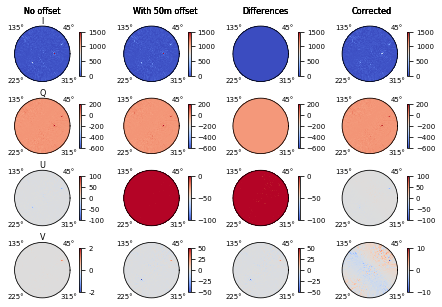

In [29]:
sky_pol = image #[image[0],image[3]]
sky_pol_off = image_off #[image_off[0],image_off[3]]
sky_pol_offc = image_c #[image_c[0],image_c[3]]

text = ['I', 'Q', 'U', 'V']
fig2,ax2 = plt.subplots(4,4, subplot_kw=dict(polar=True),figsize=(7.5,5))
plt.subplots_adjust(hspace=0.3,wspace=0.2)
plt.rc('font',size=7)
plt.rc('axes', labelsize=7)
ticks = [[0,500,1000,1500], [-600,-400,-200,0, 200], [-100,-50,0,50,100], [-2,0,2]]
ticks2 = [[0,500,1000,1500], [-600,-400,-200,0, 200], [-100,-50,0,50,100], [-10,0,10]]
ticks3 = [[0,500,1000,1500], [-600,-400,-200,0, 200], [-100,-50,0], [-50,-25, 0,25,50]]
for i in range(4):
    p2 = ax2[int(i%4),0].pcolormesh(p,t,np.real(sky_pol[i]),cmap='coolwarm',vmin=ticks[i][0], vmax = ticks[i][-1], rasterized = True)  
    cbar = plt.colorbar(p2, ax=ax2[int(i%4),0], pad = 0.1, shrink = 0.8, ticks = ticks[int(i%4)])
    cbar.ax.set_yticklabels(ticks[i]) 
    ax2[int(i%4),0].set_title(text[i], pad=0.0, fontsize = 8)
    ax2[0,0].text(2,2.5,'No offset', fontsize=8)
    ax2[int(i%4),0].set_yticklabels([])
    ax2[int(i%4),0].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax2[int(i%4),0].tick_params(axis='x',pad=-0.5)
    


###########################################################################################

    p2 = ax2[int(i%4),1].pcolormesh(p,t,np.real( sky_pol_off[i]),cmap='coolwarm',vmin=ticks3[i][0], vmax = ticks3[i][-1], rasterized = True)  
    cbar = plt.colorbar(p2, ax=ax2[int(i%4),1], pad = 0.1, shrink=0.8, ticks = ticks3[int(i%4)])
    ax2[0,1].text(2,2.5,'With 50m offset', fontsize=8)
    ax2[int(i%4),1].set_yticklabels([])
    ax2[int(i%4),1].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax2[int(i%4),1].tick_params(axis='x',pad=-0.5)
   

#########################################################################################
    p2 = ax2[int(i%4),2].pcolormesh(p,t,np.real( sky_pol_off[i]) - np.real(sky_pol[i]),cmap='coolwarm',vmin=ticks3[i][0], vmax = ticks3[i][-1], rasterized = True)
    cbar = plt.colorbar(p2, ax=ax2[int(i%4),2],pad = 0.1, shrink = 0.8, ticks = ticks3[int(i%4)])
    ax2[0,2].text(2,2.5,r'Differences', fontsize=8)
    ax2[int(i%4),2].set_yticklabels([])
    ax2[int(i%4),2].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax2[int(i%4),2].tick_params(axis='x',pad=-0.5)
    
#########################################################################################
    p2 = ax2[int(i%4),3].pcolormesh(p,t,np.real( sky_pol_offc[i]),cmap='coolwarm',vmin=ticks2[i][0], vmax = ticks2[i][-1], rasterized = True)
    cbar = plt.colorbar(p2, ax=ax2[int(i%4),3],pad = 0.1, shrink = 0.8, ticks = ticks2[int(i%4)])
    ax2[0,3].text(2,2.5,r'Corrected', fontsize=8)
    ax2[int(i%4),3].set_yticklabels([])
    ax2[int(i%4),3].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax2[int(i%4),3].tick_params(axis='x',pad=-0.5,labelsize=7)

    

#plt.savefig('plot_stokes_image_stokes_Ateam_off_nooff_correct_2MHz_real.pdf',bbox_inches='tight')
